# 5 урок: Подход динамического ценообразования на основе модели эластичности

In [1]:
from IPython.display import Image, Math

import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализаци данных
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

# Что будем делать?

- имплементируем подход на основе модели эластичности (модель, спрос, оптимизация)
- построим модель базового спроса и модель эластичности
- объединим модели для предсказания спроса
- используем метод множителей Лагранжа для решения поставленной задачи

# Задача

Ваша компания - начинающий маркетплейс: разные продавцы выставляют товары на вашей платформе, с каждой продажи вам отчисляется процент (комиссия). Сейчас у вас продается N товаров. Ваша задача - сделать алгоритм динамического ценообразования так, чтобы максимизировать прибыль вашего маркетплейса, при этом не просадить выручку:

<center>$Margin \rightarrow \max, RevenueUplift \geq 0 \%$</center>
<center>$Revenue = price * quantity$</center>
<center>$Margin = commission * price * quantity + discount * price * quantity$</center>


- Нужно выставить цены на <b>2 недели</b> вперед с <b>01.07.2021</b> по <b>14.07.2021</b>
- Цены можно менять <b>+/-20%</b> от текущей цены
- Ваше решение будет сравниваться с подходом "оставить текущие цены" (наценка = <b>0%</b>)


### Данные

Данные состоят из 3 таблиц:
- таблица с историей продаж c 01.01.2021 по 30.06.2021
- таблица с меппингом товар - категории и комиссией, отчисляемой за продажу товара
- таблица с информацией о промо и праздниках

<b>sales.parquet</b>

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `price`        | цена за дату по товару                                                                   |
| `quantity`     | количество проданного товара за дату                                                     |
| `ds`           | дата                                                                                     |

In [2]:
sales_df = pd.read_parquet("./data/sales.parquet")
sales_df["ds"] = sales_df["ds"].astype(str)
sales_df.head()

,sku_id,price,quantity,ds
207,208,1074.0,15391.0,20210101
75,76,1014.0,7.0,20210101
83,84,1456.0,2005.0,20210101
167,168,1014.0,2124.0,20210101
91,92,1032.0,3214.0,20210101


<b>categories.parquet</b>

Часто на маркетплейсах товары распределены по категориям и являются листом в категорийном дереве. Например, самокат Xiaomi входит в категорию "Электрические самокаты" (категория 3 уровня), которая в свою очередь входит в категорию "Самокаты" (категория 2 уровня), которая входит в "Спорт и отдых" (категория 1 уровня)

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `group_1`      | категория 1 уровня                                                                       |
| `group_2`      | категория 2 уровня                                                                       |
| `commission`   | комиссия с продажи товара                                                                |

In [3]:
categories_df = pd.read_parquet("./data/categories.parquet")
categories_df.head()

,sku_id,group_1,group_2,commission
39429,176,100000,100012,0.10
30387,96,100000,100005,0.12
72710,12,100006,100009,0.12
20484,62,100005,100021,0.10
17120,243,100005,100033,0.12


<b>dates.parquet</b>
| Колонка        | Пояснение                  |
|----------------|----------------------------|
| `promo`        | название промо для даты    |
| `holiday`      | название праздника для даты|
| `ds`           | дата                       |

In [4]:
dates_df = pd.read_parquet("./data/dates.parquet")
dates_df["ds"] = dates_df["ds"].astype(str)
dates_df.head()

,promo,holiday,ds
0,start_of_the_year,Православное Рождество,20210107
1,love,День защитника отечества,20210223
2,love,no,20210212
3,love,no,20210213
4,love,no,20210214


# Подход динамического ценообразования на основе модели эластичности

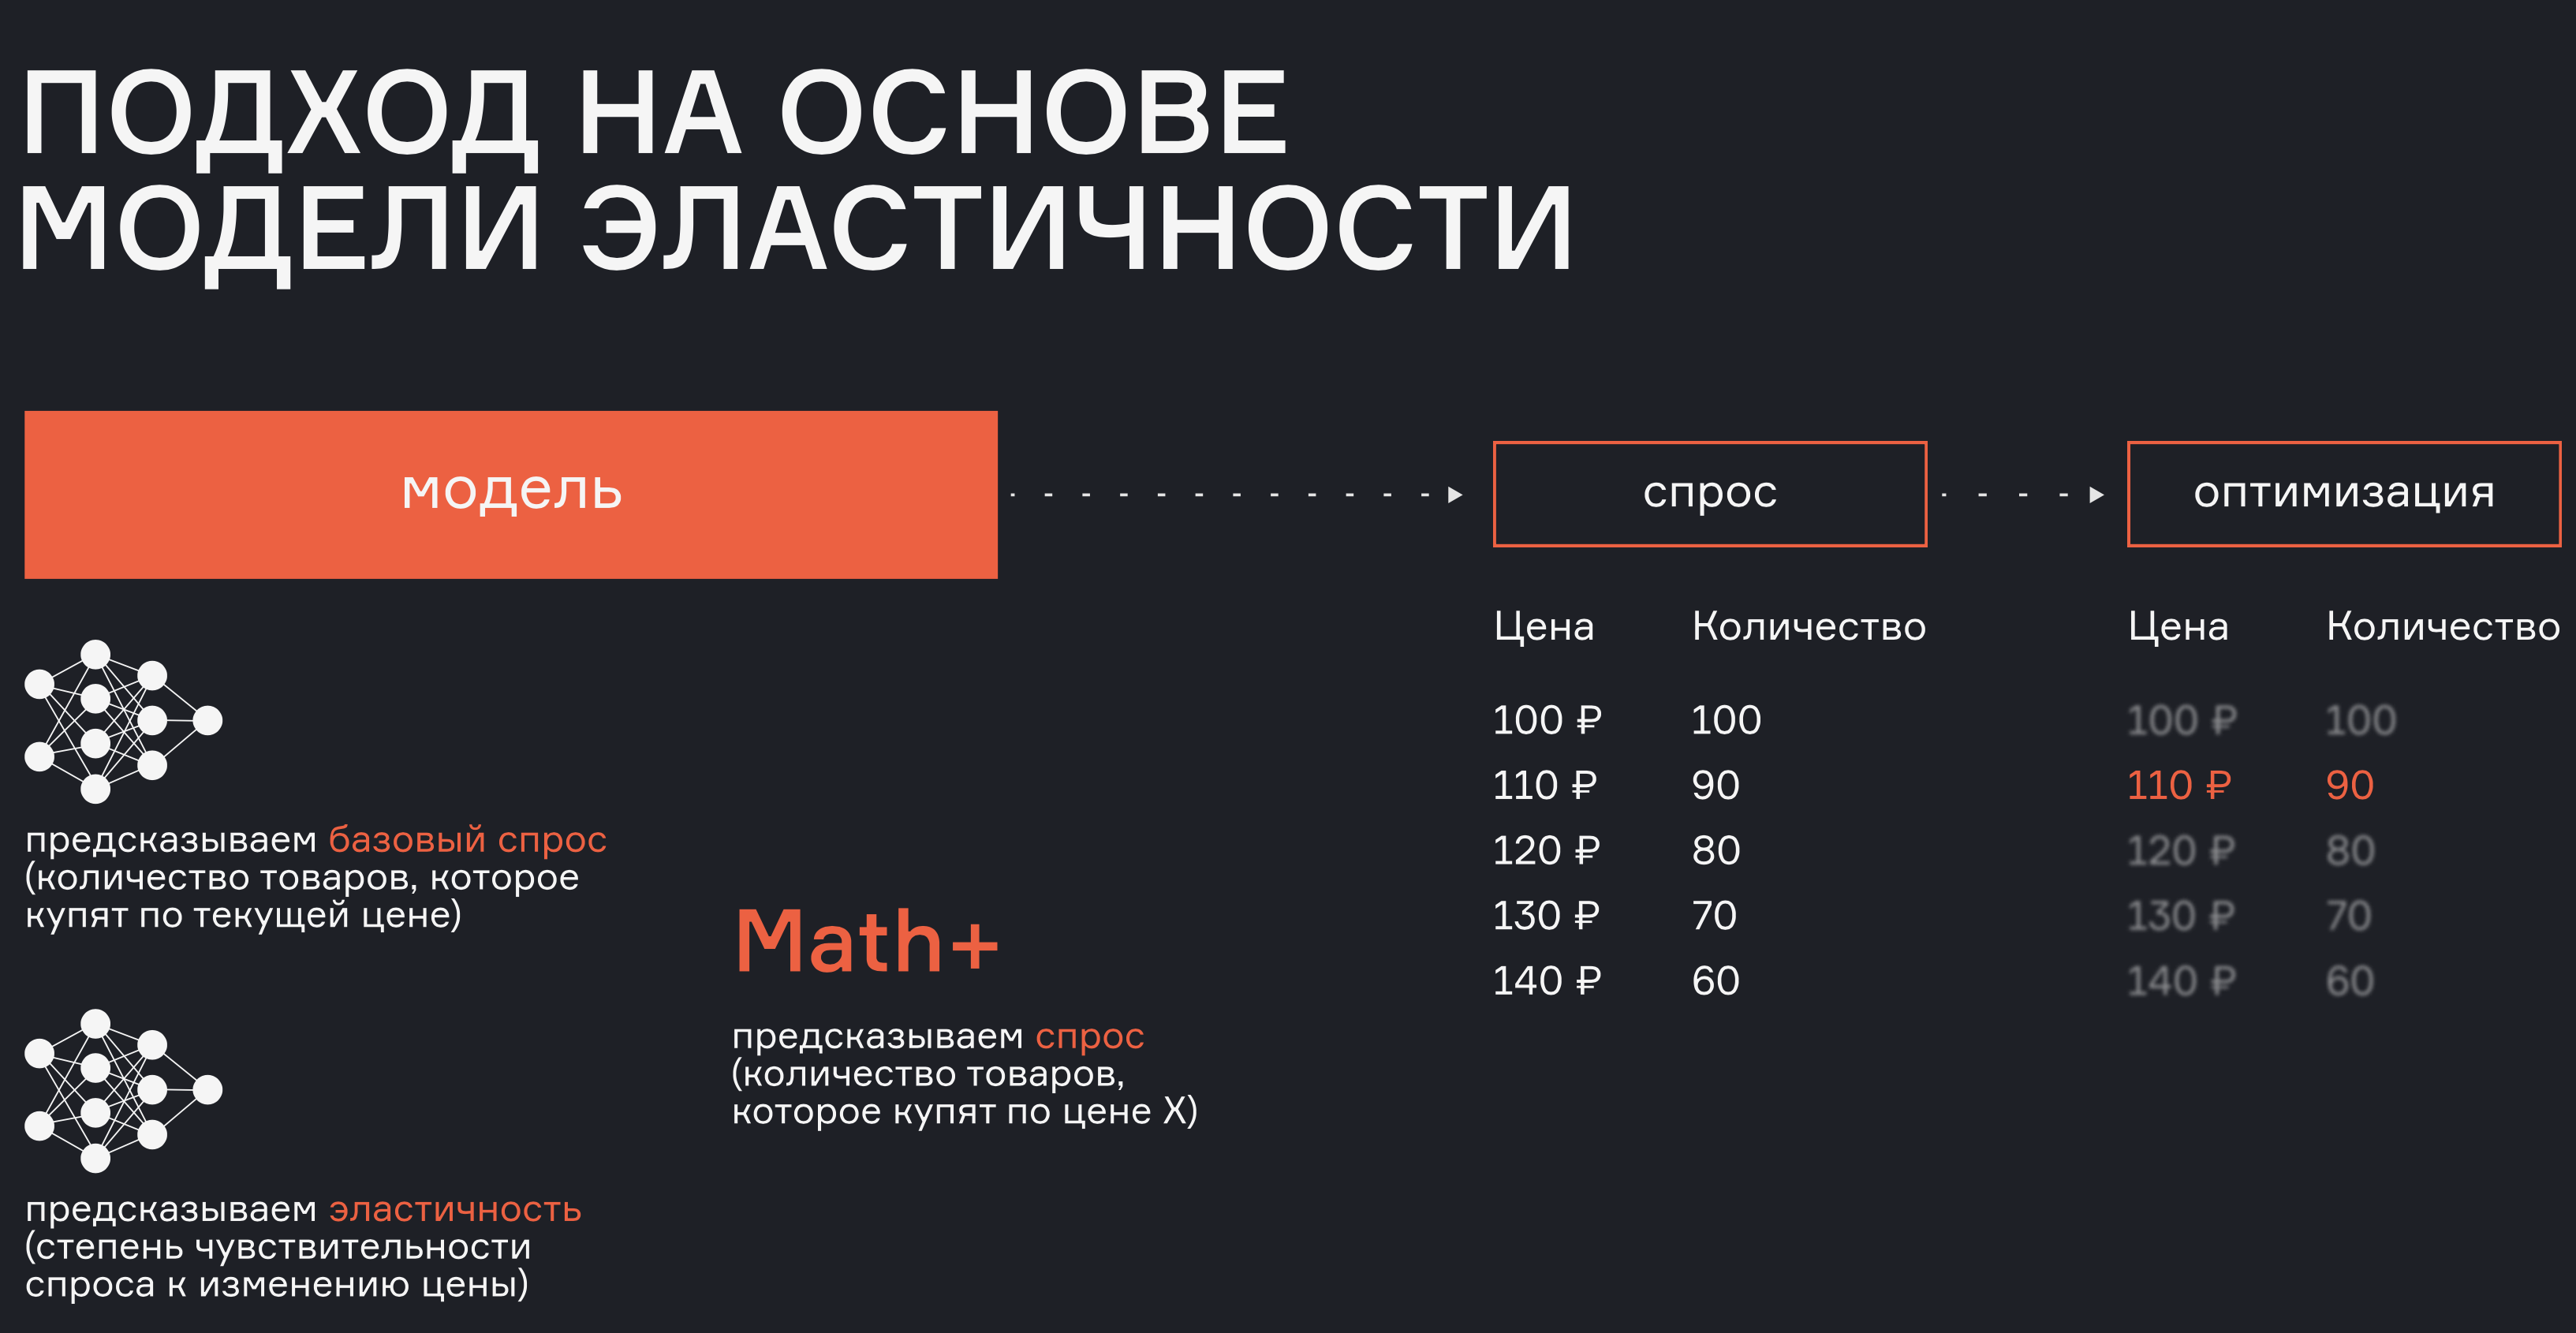

In [5]:
Image("./images/elasticity_approach.png", width=1000, height=400)

# 1. Модель

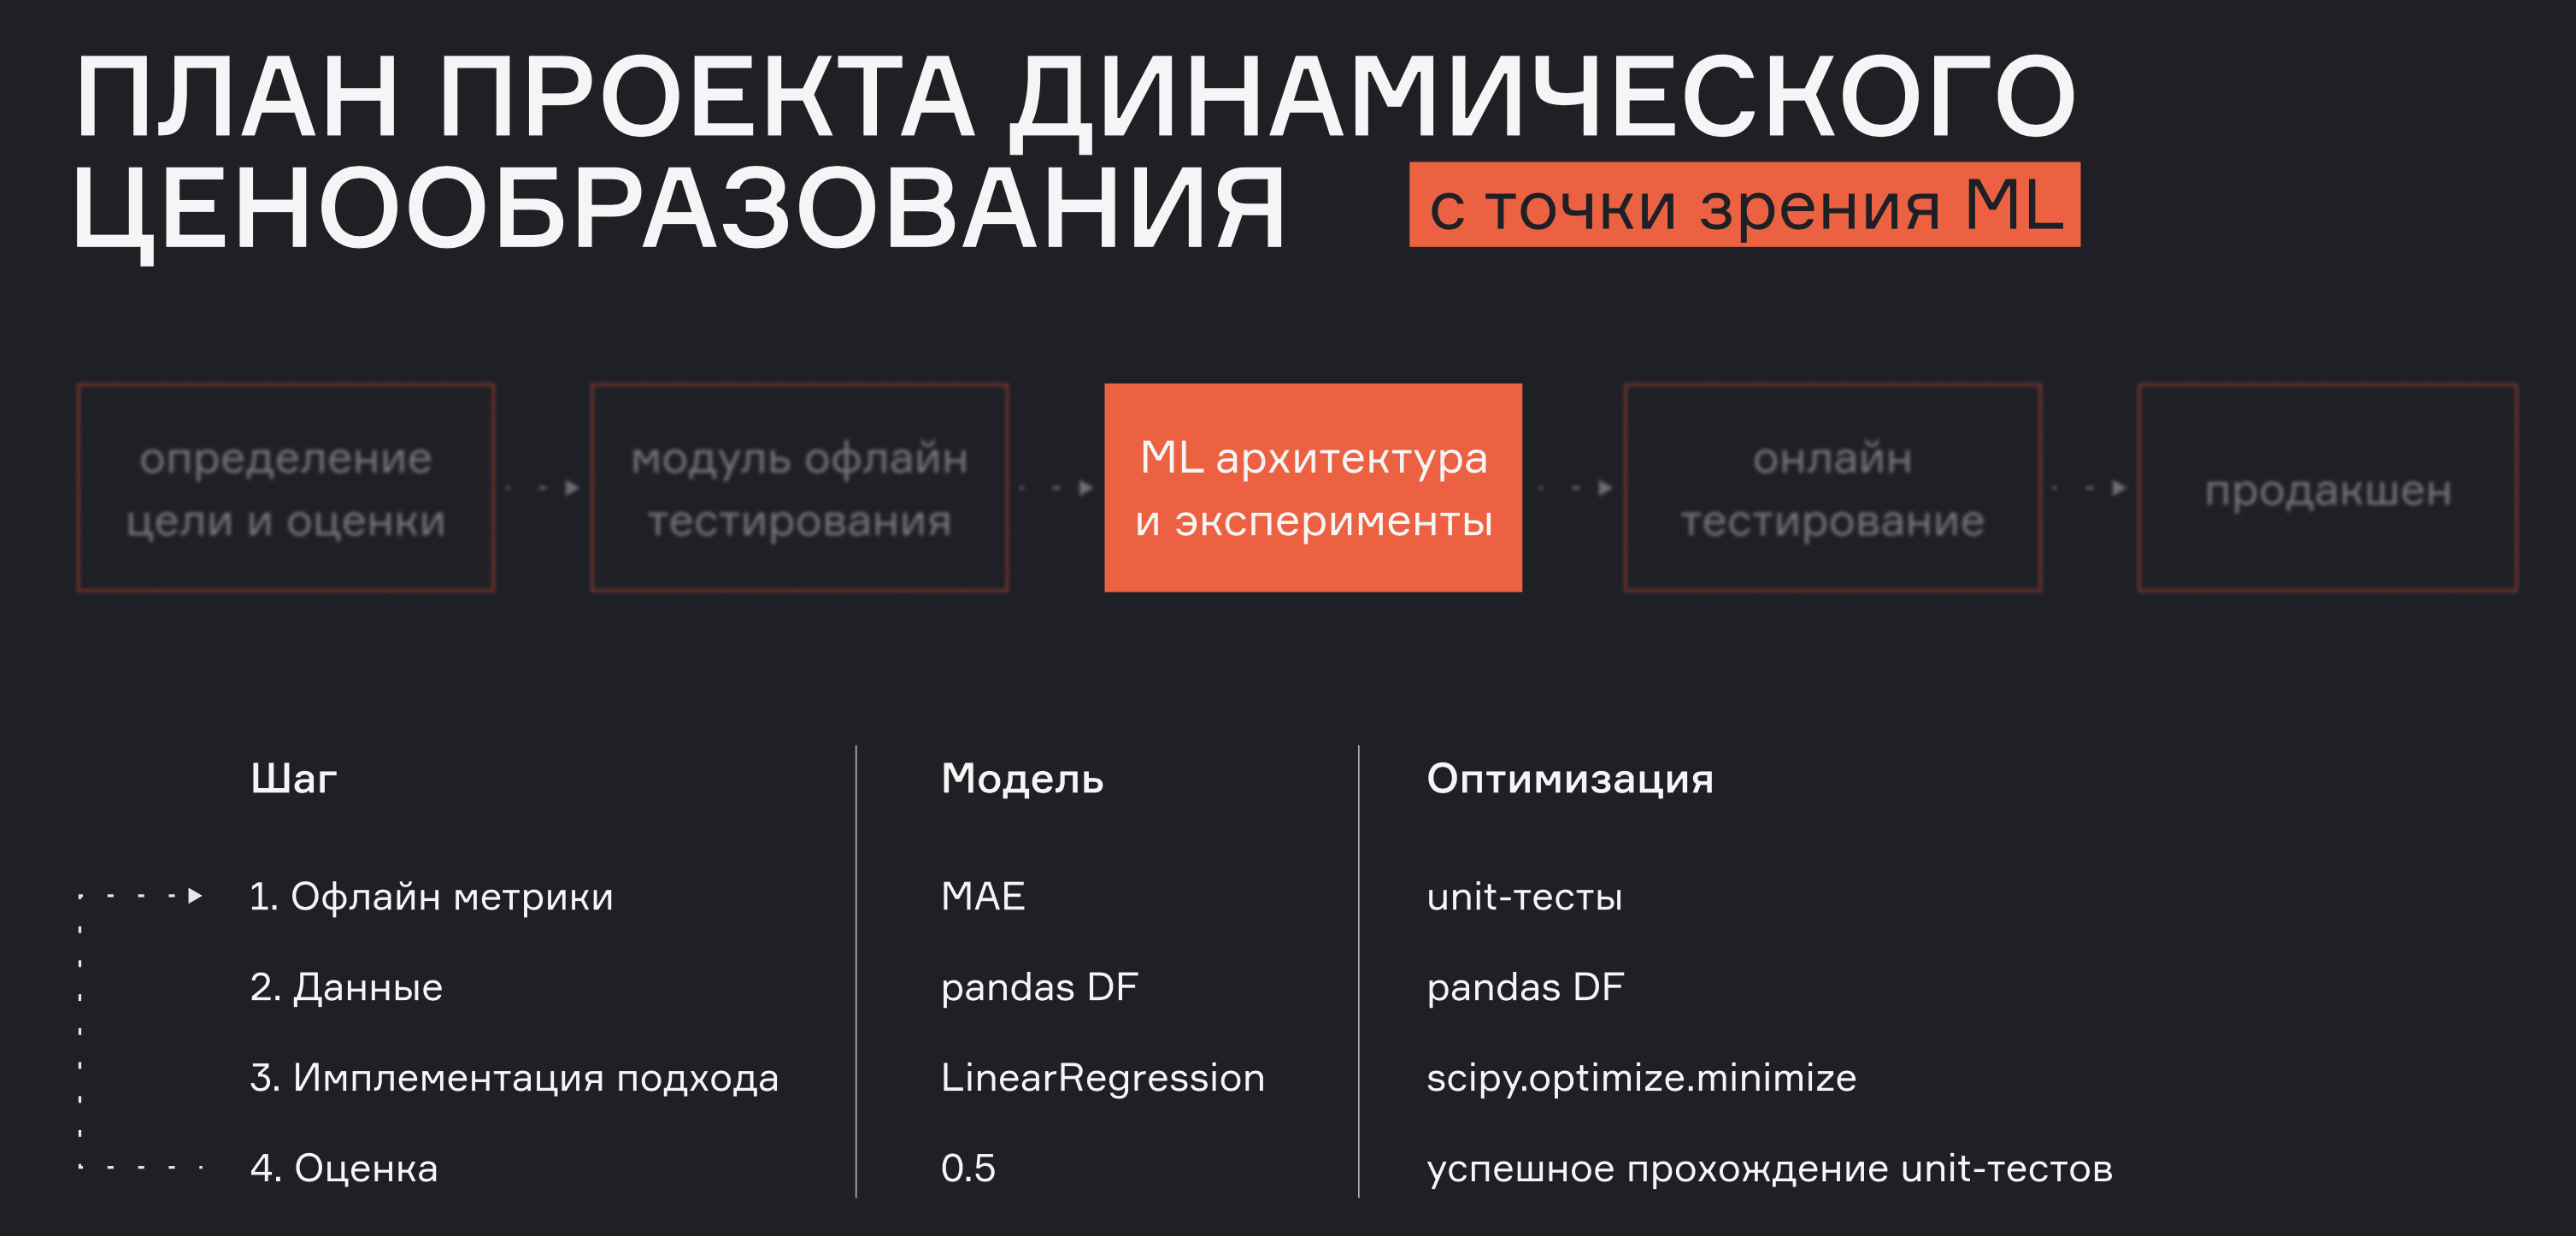

In [6]:
Image("./images/ml_plan.png", width=1000, height=400)

<b>1.1 Офлайн метрики</b>
- Выбор метрик под бизнес-задачу

<b>1.2. Данные</b>
- 1.2.1 EDA (Exploratory data analysis)
- 1.2.2 Сборка данных
- 1.2.3 Преобразование данных
- 1.2.4. Деление на train и test

<b>1.3. Имплементация подхода и оценка</b>
- 1.3.1 Модель базового спроса
- 1.3.2 Модель эластичности
- 1.3.3 Комбинация моделей (модель базового спроса + модель эластичности)

<font color="red">В подходе используется 3 модели: модель базового спроса, модель эластичности и модель, которая комбинирует выше перечисленные модели. Здесь мы объединили шаг имплементации и оценки, так как каждую модель нужно тестировать отдельно, например, чтобы параллельно вести работу над улучшением. Также, нужно в финале протестировать комбинацию моделей, так как именно она пойдет в продакшен.</font>

## 1.1 Офлайн метрики

Для начала возьмем простую метрику MAPE, чтобы оценить, насколько точно мы предсказываем спрос или эластичность

In [7]:
display(Math(r'MAPE = \frac{100%}{N}  \sum ^{N}_{i=1} |\frac{y_i-\hat y_i}{y_i}| '))

<IPython.core.display.Math object>

In [8]:
def calculate_mape(
    df: pd.DataFrame,
    true: str = "quantity",
    pred: str = "pred_quantity",
) -> float:
    df_copied = df.copy(deep=True)
    df_copied = df_copied[df_copied[true] > 0]
    df_copied["mape"] = np.abs(df_copied[true] - df_copied[pred]) / df_copied[true]
    return df_copied["mape"].mean()

## 1.2 Данные

### 1.2.1 EDA (Exploratory data analysis)
Здесь смотрим:
- пропуски (их не оказалось)
- статистики по колонкам (в пределах нормы)
- выбросы (нужно использовать фичи промо/праздники/выходные в обучении модели ИЛИ использовать фильтрацию)
- закон спроса на агрегированных данных (соблюдается)

### 1.2.2 Сборка данных

Здесь джойним все таблицы в единый датасет

In [9]:
# Джойним все данные в единый датасет
orig_df = sales_df.copy(deep=True)
orig_df = orig_df.merge(categories_df, on=["sku_id"])
orig_df = orig_df.merge(dates_df, on=["ds"])
orig_df.head()

,sku_id,price,quantity,ds,group_1,group_2,commission,promo,holiday
0,208,1074.0,15391.0,20210101,100000,100004,0.12,no,Новый год
1,76,1014.0,7.0,20210101,100008,100032,0.10,no,Новый год
2,84,1456.0,2005.0,20210101,100011,100034,0.20,no,Новый год
3,168,1014.0,2124.0,20210101,100001,100029,0.12,no,Новый год
4,92,1032.0,3214.0,20210101,100008,100032,0.10,no,Новый год


### 1.2.3 Преобразование данных

Здесь добавляем новые фичи для обучения модели, в том числе считаем дуговую эластичность

In [10]:
from typing import List, Tuple
# Добавляем новые фичи (окна, сезонные фичи)


# Расчет оконных функций
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(lambda x: x.asfreq("1D").rolling(window=window, closed="left", min_periods=0).mean().shift(shift))
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df
    
# Функция для преобразования данных
def postprocess_transform(
    df: pd.DataFrame,
    norms: List[Tuple[str, str]],
    roll_cols: List[str],
    windows: List[int],
    dropna_cols: List[str],
    lvl: str,
    shift: int,
):
    # new features
    for window in windows:
        for col in roll_cols:
            logger.info(f"Rolling window={window} days for col `{col}`")
            df = calc_rolling_window(df=df, window=window, col=col, lvl=lvl, shift=shift)

    # normalisation
    # нормализация даст сигнал модели об изменении признаков: если изменилась цена, то к какому изменению спроса это привело?
    for col1, col2 in norms:
        logger.info(f"Normalizing `{col1}` / `{col2}`")
        df[col1] = df[col1] / df[col2]

    # postprocessing
    # для однородности данных удаляем первые даты, по которым собирались окна не по полным данным
    disadvantaged_ds_list = sorted(df["ds"].unique())[:max(shift, max(windows))]
    df = df[~df["ds"].isin(disadvantaged_ds_list)]

    df = df.dropna(subset=dropna_cols)
    df = df.round(2)
    df = df.sort_values(["ds", lvl])
    return df

# Функция для подсчета дуговой эластичности
def calc_elasticity(df: pd.DataFrame, lvl: str) -> pd.DataFrame:
    # сортируем для взятия предыдущих значений
    df = df.sort_values(["ds", lvl])
    # считаем дуговую эластичность
    df["prev_quantity"] = df.groupby(lvl)["quantity"].shift(1)
    df["prev_price"] = df.groupby(lvl)["price"].shift(1)
    df["elasticity"] = (
        ((df["quantity"] - df["prev_quantity"]) / (df["price"] - df["prev_price"]))
        * ((df["price"] + df["prev_price"]) / (df["quantity"] + df["prev_quantity"]))
    )
    return df

# Функция для преобразования данных с параметрами для удобства короткого вызова
def create_features(df: pd.DataFrame, dropna_cols: List[str], lvl: str) -> pd.DataFrame:
    df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
    df = calc_elasticity(df=df, lvl=lvl)
    df = postprocess_transform(
        df=df,
        norms=[],
        roll_cols=["quantity", "elasticity", "price"],
        dropna_cols=dropna_cols,
        windows=[28],
        lvl=lvl,
        shift=14,
    )
    return df

In [11]:
df = create_features(df=orig_df, dropna_cols=["quantity", "elasticity", "price"], lvl="sku_id")
df.head()

INFO:model:Rolling window=28 days for col `quantity`
INFO:model:Rolling window=28 days for col `elasticity`
INFO:model:Rolling window=28 days for col `price`


,sku_id,price,quantity,ds,group_1,group_2,commission,promo,holiday,day_of_week,prev_quantity,prev_price,elasticity,rolling_quantity_w_28,rolling_elasticity_w_28,rolling_price_w_28
5704,1,1006.0,245.0,20210129,100000,100000,0.12,no,no,4,238.0,1014.0,-3.66,581.00,-3.39,1057.75
5705,3,1138.0,317.0,20210129,100000,100000,0.10,no,no,4,570.0,1049.0,-7.01,407.36,-27.59,1069.07
5706,4,1010.0,25.0,20210129,100002,100002,0.12,no,no,4,745.0,1023.0,146.23,223.43,128.68,1053.21
5707,5,1009.0,72.0,20210129,100003,100003,0.10,no,no,4,25.0,1016.0,-140.17,84.85,-77.88,1004.62
5708,6,1015.0,3850.0,20210129,100000,100004,0.20,no,no,4,3647.0,1014.0,54.94,2795.23,-105.74,1119.08


<font color="red">Получили данные, которые можно использовать в трейне моделей.</font>

### 1.2.4 Деление на train и test: Time Series Cross Validation

Здесь готовим функцию для TimeSeries кросс-валидации

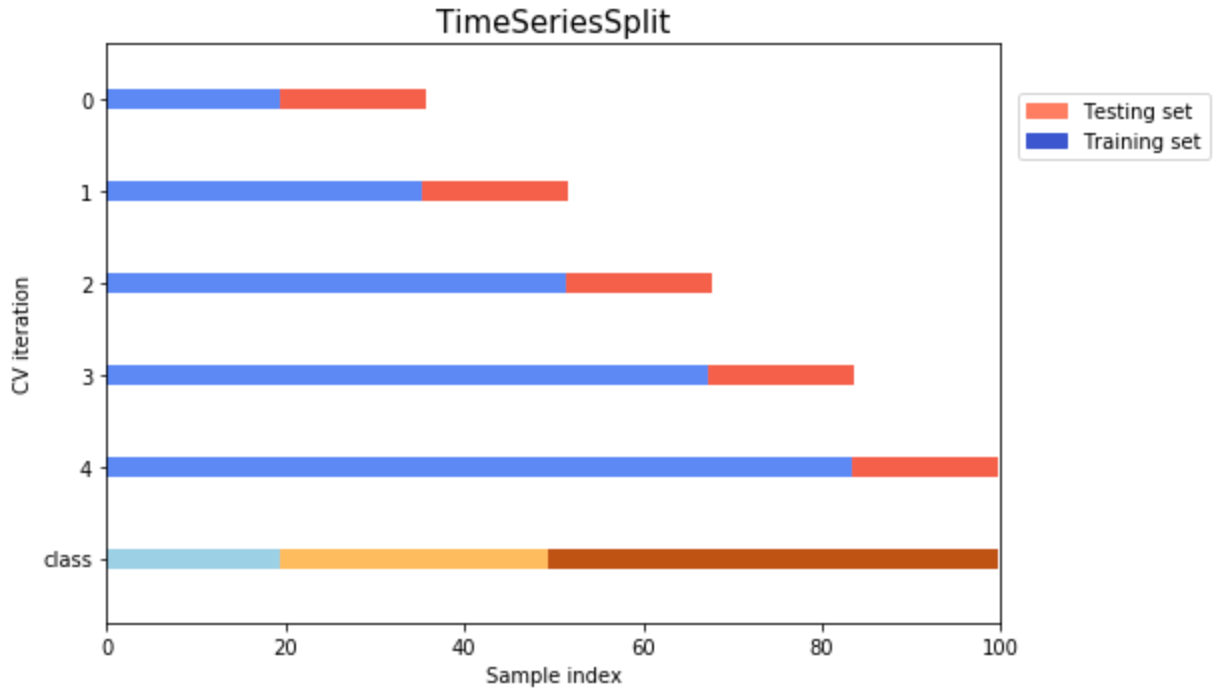

In [12]:
Image("./images/time_series_split.png", width=500, height=200)

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from typing import Tuple

# Функция для TimeSeries кросс-валидации
def get_dfs(
    df: pd.DataFrame,
    n_splits: int,
    test_size: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Возвращает 3 датасета: трейн, вал, тест
    """
    # Уникальные даты в датасете
    dates = pd.Series(sorted(df["ds"].unique()))
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    # Проход по разделениям
    for split_id, (train_idxs, test_idxs) in enumerate(tscv.split(dates)):
        train_dates = dates.iloc[train_idxs]
        test_dates = dates.iloc[test_idxs]
        val_dates = train_dates[-test_size:]
        train_dates = train_dates[:-test_size]
        
        logger.info(f"===== SPLIT {split_id} =====")
        logger.info(f"Train: {train_dates.min()} - {train_dates.max()}, size: {train_dates.shape[0]}")
        logger.info(f"Validation: {val_dates.min()} - {val_dates.max()}, size: {val_dates.shape[0]}")
        logger.info(f"Test: {test_dates.min()} - {test_dates.max()}, size: {test_dates.shape[0]}")

        train_df = df[df["ds"].isin(train_dates)]
        val_df = df[df["ds"].isin(val_dates)]
        test_df = df[df["ds"].isin(test_dates)]
        yield train_df, val_df, test_df

In [14]:
N_SPLITS = 3
TEST_SIZE = 14

## 1.3 Имплементация подхода и оценка

Модели:
- Модель базового спроса
- Модель эластичности
- Комбинация моделей (модель базового спроса + модель эластичности)

Для каждой модели делаем:
- Выбор модели
- Подсчет офлайн метрик
- Интерпретация фичей
- Визуализация предсказаний

In [15]:
from typing import List, Dict, Any, Callable, Optional, Callable

# Пайплайн для валидации модели
def run_pipeline(
    df: pd.DataFrame,
    target: str,
    n_splits: int,
    test_size: int,
    predict_func: Callable,
    W: int,
) -> float:
    mapes = []
    for train_df, val_df, test_df in get_dfs(
        df=df,
        n_splits=n_splits,
        test_size=test_size,
    ):
        # предсказываем
        test_df[f"pred_{target}"] = predict_func(df=test_df, W=W)
        # считаем качество
        # лучше считать качество с учетом постпроцессинга (включая clip), но сейчас этим пренебрежём
        mape = calculate_mape(
            df=test_df,
            true=target,
            pred=f"pred_{target}",
        )
        mapes.append(mape)
        logger.info(f"MAPE: {mape}")

    mean_mape = np.mean(mapes)
    logger.info(f"Mean MAPE: {mean_mape}")
    return train_df, val_df, test_df

In [16]:
# Функция для визуализации предсказаний
def plot_time_series(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    sku_id: int,
    target: str,
    ylim: Optional[Tuple[float]] = None,
) -> None:
    # Сборка данных
    sku_train_df = train_df[train_df["sku_id"] == sku_id]
    sku_val_df = val_df[val_df["sku_id"] == sku_id]
    sku_test_df = test_df[test_df["sku_id"] == sku_id]

    train = sku_train_df[[target, "ds"]].set_index("ds")
    val = sku_val_df[[target, "ds"]].set_index("ds")
    test = sku_test_df[[target, "ds"]].set_index("ds")
    pred = sku_test_df[[f"pred_{target}", "ds"]].set_index("ds")

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Train")
    plt.plot(val, label="Validation")
    plt.plot(test, label="Test")
    plt.plot(pred, label="Prediction")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.title(f"Time Series Train/Val/Test/Pred for sku_id={sku_id}")
    plt.xlabel("ds")
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.xticks([
        ds if ds.endswith("01") else "" 
        for ds in sku_train_df["ds"].tolist() + sku_val_df["ds"].tolist() + sku_test_df["ds"].tolist()
    ])
    plt.show()

### 1.3.1 Модель базового спроса

#### 1.3.1.1 Выбор модели

В качестве модели базового спроса возьмем среднее количество продаж за 28 дней

In [17]:
# Функция для предсказания базового спроса
def predict_base_demand(
    df: pd.DataFrame,
    W: int,
) -> List[float]:
    preds = df[f"rolling_quantity_w_{W}"]
    return preds

#### 1.3.1.2 Подсчет офлайн метрик

In [18]:
train_df, val_df, test_df = run_pipeline(
    df=df,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    target="quantity",
    predict_func=predict_base_demand,
    # среднее за 28 дней
    W=28,
)

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210129 - 20210505, size: 97
INFO:model:Validation: 20210506 - 20210519, size: 14
INFO:model:Test: 20210520 - 20210602, size: 14
INFO:model:MAPE: 2.436144570523636
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210129 - 20210519, size: 111
INFO:model:Validation: 20210520 - 20210602, size: 14
INFO:model:Test: 20210603 - 20210616, size: 14
INFO:model:MAPE: 2.4316399881050317
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20210129 - 20210602, size: 125
INFO:model:Validation: 20210603 - 20210616, size: 14
INFO:model:Test: 20210617 - 20210630, size: 14
INFO:model:MAPE: 2.3007275065417345
INFO:model:Mean MAPE: 2.3895040217234675


#### 1.3.1.3 Интерпретация фичей

Если не устраивает качество модели, можно дебажить с помощью shap values, если есть такая возможность - подробнее [тут](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html). Мы этот шаг пропустим, так как у нас модель - "среднее", в ней не используются никакие фичи.

#### 1.3.1.4 Визуализация предсказаний

Для дебага можно визуализировать данные удобным способом, например, изображение TimeSeries может помочь обнаружить недостатки модели

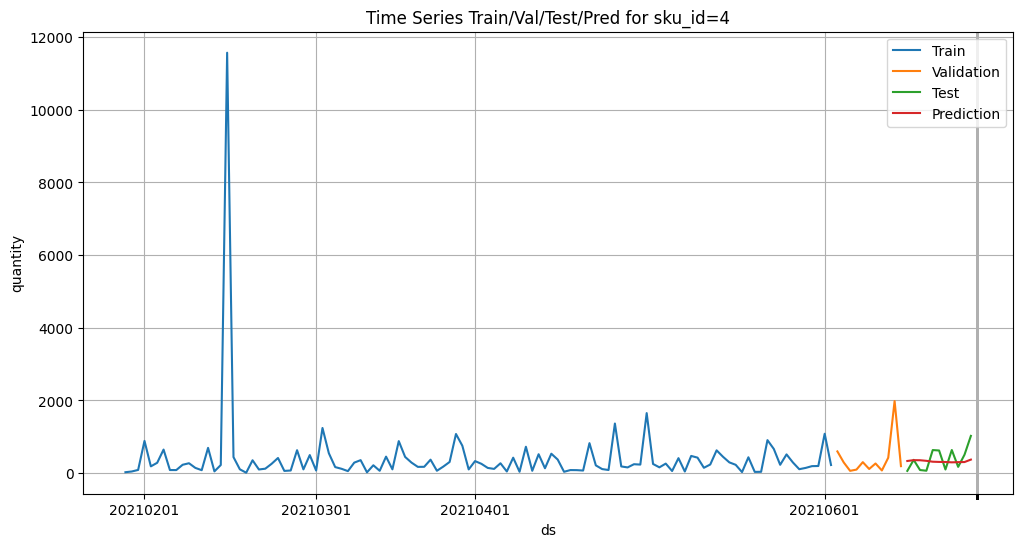

In [19]:
plot_time_series(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    sku_id=4,
    target="quantity",
)

<font color="red">На графике можно увидеть, что модель предсказывает среднее, как предполагалось, и есть много моментов, над которыми стоит поработать (мы по сути вообще не используем в модели какую-либо дополнительную информацию).</font>

### 1.3.2 Модель эластичности

#### 1.3.2.1 Выбор модели

В качестве модели эластичности возьмем среднее дуговой эластичности за 28 дней

In [20]:
display(Math(r'E^p_d = \frac{Q_2-Q_1}{P_2-P_1} * \frac{P_2+P_1}{Q_2+Q_1}'))

<IPython.core.display.Math object>

In [21]:
# Функция для предсказания эластичности
def predict_elasticity(
    df: pd.DataFrame,
    W: int,
) -> List[float]:
    # клипаем, чтобы избежать обратных кривых
    preds =  df[f"rolling_elasticity_w_{W}"].clip(upper=0, lower=-5)
    return preds

#### 1.3.2.2 Подсчет офлайн метрик

In [22]:
train_df, val_df, test_df = run_pipeline(
    df=df,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    target="elasticity",
    predict_func=predict_elasticity,
    # среднее за 28 дней
    W=28,
)

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210129 - 20210505, size: 97
INFO:model:Validation: 20210506 - 20210519, size: 14
INFO:model:Test: 20210520 - 20210602, size: 14
INFO:model:MAPE: 1.2624058598602852
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210129 - 20210519, size: 111
INFO:model:Validation: 20210520 - 20210602, size: 14
INFO:model:Test: 20210603 - 20210616, size: 14
INFO:model:MAPE: 1.234410247284025
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20210129 - 20210602, size: 125
INFO:model:Validation: 20210603 - 20210616, size: 14
INFO:model:Test: 20210617 - 20210630, size: 14
INFO:model:MAPE: 1.4124084048111039
INFO:model:Mean MAPE: 1.3030748373184713


#### 1.3.2.3 Интерпретация фичей

Если не устраивает качество модели, можно дебажить с помощью shap values, если есть такая возможность - подробнее [тут](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html). Мы этот шаг пропустим, так как у нас модель - "среднее", в ней не используются никакие фичи.

#### 1.3.2.4 Визуализация предсказаний

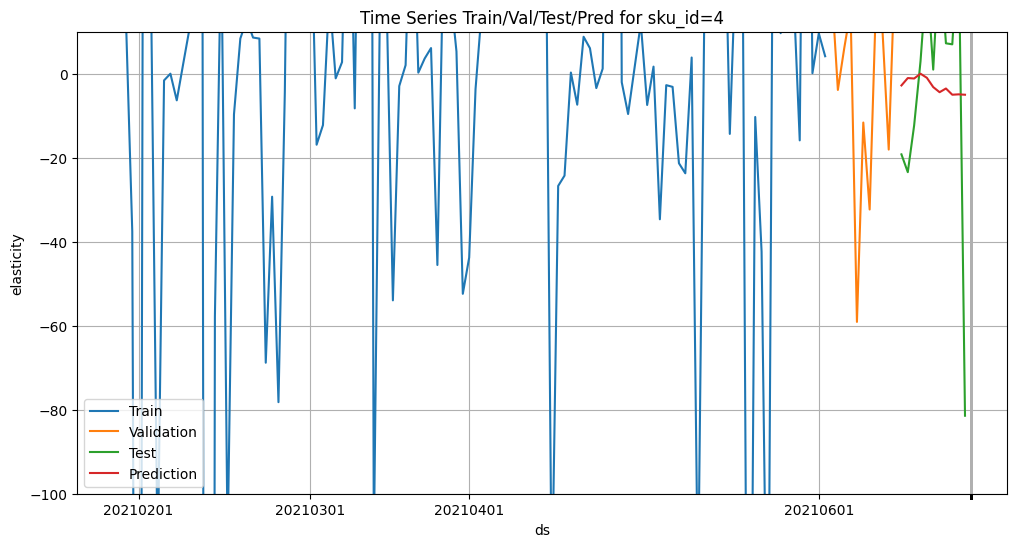

In [23]:
plot_time_series(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    sku_id=4,
    target="elasticity",
    ylim=(-100, 10),
)

<font color="red">На графике можно увидеть, что модель предсказывает среднее, как предполагалось, и есть много моментов, над которыми стоит поработать (мы по сути вообще не используем в модели какую-либо дополнительную информацию).</font>

### 1.3.3 Комбинация моделей (модель базового спроса + модель эластичности)

Обязательно проводите тестирование каждой части вашей архитектуры и то, как архитектура работает целиком (вспомним плюсы BackTest'а)

#### 1.3.3.1 Выбор модели

In [24]:
display(Math(r'demand_t = BaseDemand_t * (\frac{price_t}{price_{t-1}})^{E^p_d}'))

<IPython.core.display.Math object>

In [25]:
# Функция для предсказания комбинации моделей
def predict_demand(
    df: pd.DataFrame,
    W: int,
) -> List[float]:
    df["base_quantity"] = df[f"rolling_quantity_w_{W}"]
    # клипаем, чтобы избежать обратных кривых
    df["elasticity"] =  df[f"rolling_elasticity_w_{W}"].clip(upper=0, lower=-5)
    df["price_norm"] = df["price"] / df[f"rolling_price_w_{W}"]
    preds = df["base_quantity"] * pow(df["price_norm"], df["elasticity"])
    return preds

#### 1.3.3.2 Подсчет офлайн метрик

In [26]:
train_df, val_df, test_df = run_pipeline(
    df=df,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    target="quantity",
    predict_func=predict_demand,
    # среднее за 28 дней
    W=28,
)

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210129 - 20210505, size: 97
INFO:model:Validation: 20210506 - 20210519, size: 14
INFO:model:Test: 20210520 - 20210602, size: 14
INFO:model:MAPE: 2.5008002659068946
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210129 - 20210519, size: 111
INFO:model:Validation: 20210520 - 20210602, size: 14
INFO:model:Test: 20210603 - 20210616, size: 14
INFO:model:MAPE: 2.552274720602321
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20210129 - 20210602, size: 125
INFO:model:Validation: 20210603 - 20210616, size: 14
INFO:model:Test: 20210617 - 20210630, size: 14
INFO:model:MAPE: 2.3647351206571745
INFO:model:Mean MAPE: 2.4726033690554634


#### 1.3.3.3 Интерпретация фичей

Если не устраивает качество модели, можно дебажить с помощью shap values, если есть такая возможность - подробнее [тут](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html). Мы этот шаг пропустим, так как у нас модель - "среднее", в ней не используются никакие фичи.

#### 1.3.3.4 Визуализация предсказаний

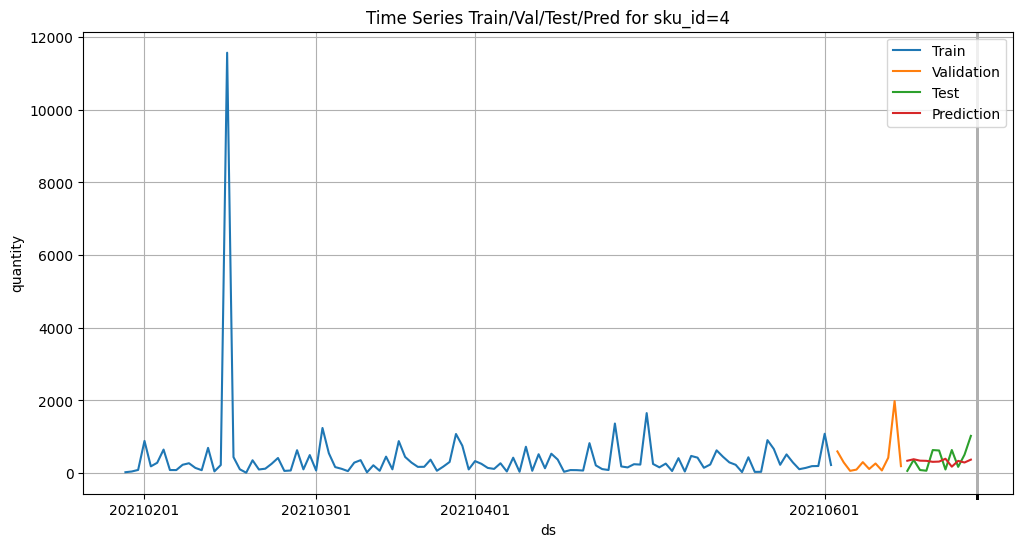

In [27]:
plot_time_series(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    sku_id=4,
    target="quantity",
)

<font color="red">Здесь, в отличие от базового спроса, видим не просто предсказание среднего, а предсказание спроса, поправленное на эластичность.</font>

<font color="red">Сейчас мы используем самые тривиальные модели, которые только можно применить, так как хочется сфокусироваться на основной идее подхода. На практике вам следует поработать над каждой моделью, чтобы добиться лучшего качества.</font>

# 2. Спрос

Вспомним про наши условия и ограничения:
- Нужно выставить цены на <b>2 недели</b> вперед с <b>01.07.2021</b> по <b>14.07.2021</b>
- Цены можно менять <b>+/-20%</b> от текущей цены

В этом разделе мы применим обученную модель для предсказания спроса для разных цен.

In [28]:
START_DS, END_DS = "20210701", "20210714"

# Находим текущие цены
pred_df = sales_df.copy(deep=True)[["sku_id", "price", "ds"]]
pred_df = pred_df.sort_values(by=["sku_id", "ds"])
pred_df = pred_df.groupby("sku_id").last().reset_index()
pred_df = pred_df.drop(columns=["ds"])

# Наджойниваем даты для предсказания
pred_dates_df = dates_df[dates_df["ds"].between(START_DS, END_DS)]
pred_df = pred_df.join(pred_dates_df, how="cross")

# Конкатим с историческими данными, чтобы посчитать оконные фичи
cols = pred_df.columns.tolist() + ["quantity"]
pred_df["quantity"] = None
pred_df = pd.concat([orig_df.copy(deep=True)[cols], pred_df[cols]])

# Считаем фичи
pred_df = create_features(df=pred_df, dropna_cols=["price"], lvl="sku_id")
pred_df = pred_df[pred_df["ds"].between(START_DS, END_DS)]

# Наджойниваем категории и комиссии
pred_df = pred_df.merge(categories_df, how="inner", on=["sku_id"])

# Рассчитываем новые цены с учетом "+/-20% от текущей цены"
# Если у вас есть ограничения на цены, то как раз здесь их можно применить
discounts_df = pd.DataFrame({"discount": np.arange(-0.2, 0.21, 0.01).round(2).tolist()})
pred_df = pred_df.join(discounts_df, how="cross")
pred_df["price"] = (pred_df["price"] +  pred_df["price"] * pred_df["discount"]).round(2)

# # предсказываем спрос с помощью модели
pred_df["base_quantity"] = predict_base_demand(df=pred_df, W=28)
pred_df["elasticity"] = predict_elasticity(df=pred_df, W=28)
pred_df["price_norm"] = pred_df["price"] / pred_df["rolling_price_w_28"]
pred_df["quantity"] = pred_df["base_quantity"] * pow(pred_df["price_norm"], pred_df["elasticity"])

# quantity не может быть меньше 0
pred_df["quantity"] = np.clip(pred_df["quantity"], a_min=0.0, a_max=None)
# если у вас есть ограничения на сток, то как раз здесь их можно применить

pred_df.head()

INFO:model:Rolling window=28 days for col `quantity`
INFO:model:Rolling window=28 days for col `elasticity`
INFO:model:Rolling window=28 days for col `price`


,sku_id,price,promo,holiday,ds,quantity,day_of_week,prev_quantity,prev_price,elasticity,rolling_quantity_w_28,rolling_elasticity_w_28,rolling_price_w_28,group_1,group_2,commission,discount,base_quantity,price_norm
0,1,834.40,no,no,20210701,924.6,3,1662.0,1043.0,0.0,924.6,49.82,1035.28,100000,100000,0.12,-0.20,924.6,0.805966
1,1,844.83,no,no,20210701,924.6,3,1662.0,1043.0,0.0,924.6,49.82,1035.28,100000,100000,0.12,-0.19,924.6,0.816040
2,1,855.26,no,no,20210701,924.6,3,1662.0,1043.0,0.0,924.6,49.82,1035.28,100000,100000,0.12,-0.18,924.6,0.826115
3,1,865.69,no,no,20210701,924.6,3,1662.0,1043.0,0.0,924.6,49.82,1035.28,100000,100000,0.12,-0.17,924.6,0.836189
4,1,876.12,no,no,20210701,924.6,3,1662.0,1043.0,0.0,924.6,49.82,1035.28,100000,100000,0.12,-0.16,924.6,0.846264


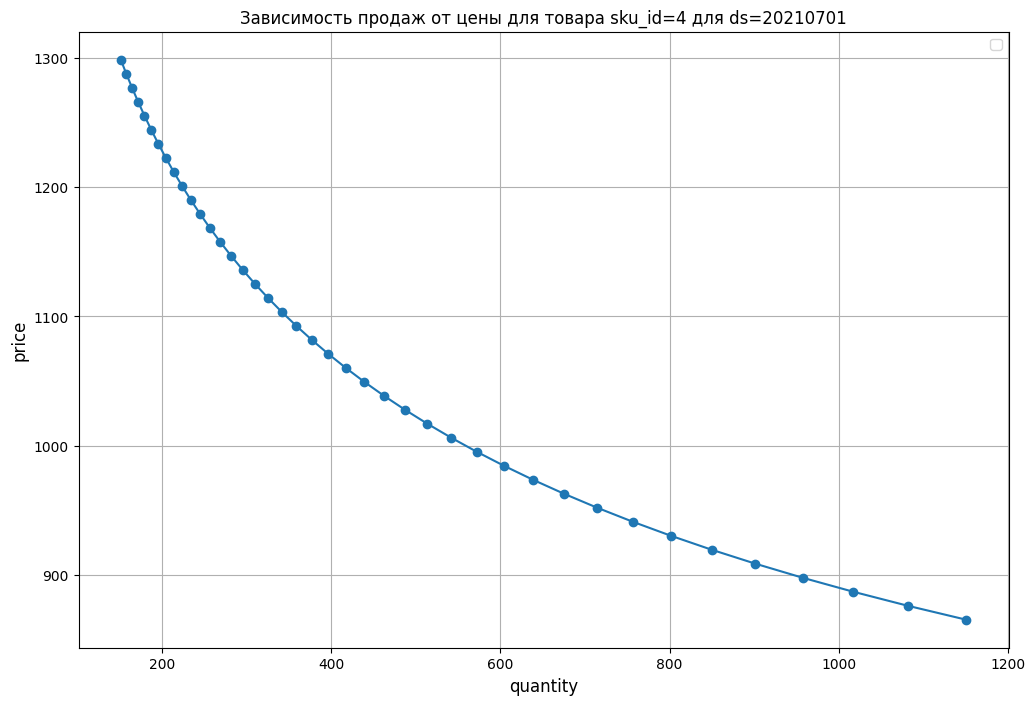

In [29]:
# Изобразим получившуюся кривую эластичности по товару SKU_ID
SKU_ID = 4  # id товара
plot_df = pred_df[(pred_df["sku_id"] == SKU_ID) & (pred_df["ds"] == START_DS)]

plt.figure(figsize=(12, 8))
plt.plot(plot_df["quantity"], plot_df["price"], marker='o')
plt.ylabel("price", fontsize=12)
plt.xlabel("quantity", fontsize=12)
plt.title(f"Зависимость продаж от цены для товара sku_id={SKU_ID} для ds={START_DS}", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<font color="red">На графике можно увидеть закон спроса, причем кривая выглядит лучше, чем мы видели в практике к уроку про подход динамического ценообразования на основе модели спроса (как из учебников по экономике) - все благодаря основной концепции подхода динамического ценообразования на основе модели эластичности.</font>

# 3. Оптимизация

Цель нашего проекта - максимизировать прибыль и не просадить выручку:
<center>$Margin \rightarrow \max, RevenueUplift \geq 0 \%$</center>
<center>$Revenue = price * quantity$</center>
<center>$Margin = commission * price * quantity + discount * price * quantity$</center>

Тут мы будем искать лучшие цены под нашу задачу с помощью метода множителей Лагранжа.

In [30]:
import logging
from typing import List, Dict, Any

import numpy as np
import pandas as pd

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(f"Metric: {maximized_column}", extra={"value": optimal_statistics.get(maximized_column)})

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        log_dict = {
            "constraint value": round(constraint, 3),
            "optimal value": round(optimal_value, 3),
            "uplift (abs)": round(optimal_value - constraint, 3),
            "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
        }
        logger.info(f"Metric: {metric}")
        for key, value in log_dict.items():
            logger.info(f"{key}= {value}")


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
    maximized_column: str,
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
        maximized_column=maximized_column,
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df

In [31]:
# Подсчет метрик
pred_df["margin"] = pred_df["commission"] * pred_df["price"] * pred_df["quantity"] + pred_df["discount"] * pred_df["price"] * pred_df["quantity"]
pred_df["revenue"] = pred_df["price"] * pred_df["quantity"]

# Считаем ограничения
control_revenue = pred_df[pred_df["discount"] == 0]["revenue"].sum()

optimal_df = optimize(
    df=pred_df,
    # перебираем разные lambda для выручки
    lambda_config={
        "revenue": np.arange(0.0, 0.05, 0.001).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="margin",
    # указываем ограничения
    constraints={
        "revenue": control_revenue,
    },
    levels=["sku_id", "ds"],
    price_column="discount",
)

INFO:__main__:Start choosing optimal prices
INFO:__main__:Start calculating lagrangians, 50 lambda combinations
INFO:__main__:Ended calculating lagrangians
INFO:__main__:
  lambda_combination        margin       revenue
0        revenue=0.0  8.475108e+09  2.625603e+10
1      revenue=0.001  8.475108e+09  2.625635e+10
2      revenue=0.002  8.474943e+09  2.638518e+10
3      revenue=0.003  8.474942e+09  2.638542e+10
4      revenue=0.004  8.474752e+09  2.643590e+10
INFO:__main__:
   lambda_combination        margin       revenue
49      revenue=0.049  8.421767e+09  2.831445e+10
INFO:__main__:Metric: margin
INFO:__main__:Metric: revenue
INFO:__main__:constraint value= 28311986824.666
INFO:__main__:optimal value= 28314454057.11
INFO:__main__:uplift (abs)= 2467232.445
INFO:__main__:uplift (pct)= 0.009
INFO:__main__:Ended choosing optimal prices


In [32]:
# Посмотрим распределение скидок
optimal_df["discount"].value_counts(normalize=True)

0.20    0.559102
0.00    0.155499
0.11    0.142541
0.13    0.135272
0.01    0.000948
0.04    0.000948
0.18    0.000948
0.19    0.000948
0.12    0.000632
0.15    0.000632
0.16    0.000632
0.17    0.000632
0.05    0.000316
0.06    0.000316
0.09    0.000316
0.14    0.000316
Name: discount, dtype: float64

In [33]:
# Считаем аплифт на предсказаниях
control_margin = pred_df[pred_df["discount"] == 0]["margin"].sum()
control_revenue = pred_df[pred_df["discount"] == 0]["revenue"].sum()

test_margin = optimal_df["margin"].sum()
test_revenue = optimal_df["revenue"].sum()

print(f"Control margin: {round(control_margin)} руб.")
print(f"Test margin: {round(test_margin)} руб.")
print(f"Uplift: {round(test_margin * 100 / control_margin - 100)} %")

print(f"Control revenue: {round(control_revenue)} руб.")
print(f"Test revenue: {round(test_revenue)} руб.")
print(f"Uplift: {round(test_revenue * 100 / control_revenue - 100)} %")

Control margin: 3990668581 руб.
Test margin: 8421767009 руб.
Uplift: 111 %
Control revenue: 28311986825 руб.
Test revenue: 28314454057 руб.
Uplift: 0 %


<font color="red">Получили аплифт по прибыли и не просадили выручку.</font>

# Резюме

- подготовили пайплайн динамического ценообразования (модель, спрос, оптимизация) через построение модели эластичности и модели базового спроса
- обсудили этапы подготовки моделей (офлайн метрики, данные, имплементация подхода и оценка)
    - выбрали метрику для оценки качества модели базового спроса, модели эластичности и комбинации этих моделей
    - подготовили данные для обучения моделей, в том числе посчитали таргет для модели эластичности - эластичность
    - имплементировали простые варианты моделей и оценили их
- повторили, как строить датасет для этапа "спрос"
- выбрали оптимальные цены/наценки для максимизации одной метрики с ограничениями